In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import ta
import yfinance as yf

In [2]:
# Existing code for data fetching
ticker = 'GME'
stockPrices = yf.download(ticker, '1981-01-01', '2024-07-22')

[*********************100%%**********************]  1 of 1 completed


In [3]:
stockPrices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,2.40625,2.51500,2.38125,2.51250,1.691667,76216000
2002-02-14,2.54375,2.54875,2.48125,2.50000,1.683250,11021600
2002-02-15,2.50000,2.50625,2.46250,2.48750,1.674834,8389600
2002-02-19,2.47500,2.47500,2.34375,2.38750,1.607504,7410400
2002-02-20,2.40000,2.46875,2.38125,2.46875,1.662209,6892800


In [4]:
stockPrices.isnull()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,False,False,False,False,False,False
2002-02-14,False,False,False,False,False,False
2002-02-15,False,False,False,False,False,False
2002-02-19,False,False,False,False,False,False
2002-02-20,False,False,False,False,False,False
...,...,...,...,...,...,...
2024-07-15,False,False,False,False,False,False
2024-07-16,False,False,False,False,False,False
2024-07-17,False,False,False,False,False,False


In [5]:
stockPrices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5646 entries, 2002-02-13 to 2024-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5646 non-null   float64
 1   High       5646 non-null   float64
 2   Low        5646 non-null   float64
 3   Close      5646 non-null   float64
 4   Adj Close  5646 non-null   float64
 5   Volume     5646 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 308.8 KB


In [6]:
stockPrices.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
stockPrices.shape

(5646, 6)

In [8]:
stockPrices.size

33876

In [9]:
stockPrices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5646.000000,5646.000000,5646.000000,5646.000000,5646.000000,5.646000e+03
mean,9.371573,9.688580,9.058711,9.352457,8.018803,1.453099e+07
std,10.389287,11.038386,9.748765,10.295986,10.540438,2.981795e+07
min,0.712500,0.735000,0.642500,0.700000,0.638793,2.600000e+05
25%,3.670625,3.745000,3.600625,3.675000,2.920049,5.394800e+06
50%,5.972500,6.055000,5.866250,5.971250,4.234187,9.626400e+06
75%,10.551875,10.743125,10.382500,10.567500,7.641419,1.518860e+07
max,94.927498,120.750000,72.877502,86.877502,86.877502,7.886316e+08


In [10]:
# Clean the column names
stockPrices.columns = stockPrices.columns.str.strip()

In [11]:
# # Check if the required columns are present
# required_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
# for col in required_columns:
#     if col not in stockPrices.columns:
#         print(f"Column '{col}' is missing from the dataset.")
#         exit()

In [12]:
# # Convert the 'Date' column to datetime
# stockPrices['Date'] = pd.to_datetime(stockPrices['Date'])

# # Set the 'Date' column as the index
# stockPrices.set_index('Date', inplace=True)

In [13]:
# Compute additional features
stockPrices['SMA_50'] = stockPrices['Close'].rolling(window=50).mean()
stockPrices['EMA_20'] = stockPrices['Close'].ewm(span=20, adjust=False).mean()
stockPrices['RSI'] = ta.momentum.rsi(stockPrices['Close'], window=14)
stockPrices['MACD'] = ta.trend.macd(stockPrices['Close'])
stockPrices['Bollinger_High'] = ta.volatility.bollinger_hband(stockPrices['Close'])
stockPrices['Bollinger_Low'] = ta.volatility.bollinger_lband(stockPrices['Close'])
stockPrices['ATR'] = ta.volatility.average_true_range(stockPrices['High'], stockPrices['Low'], stockPrices['Close'])
stockPrices['Stochastic'] = ta.momentum.stoch(stockPrices['High'], stockPrices['Low'], stockPrices['Close'])
stockPrices['OBV'] = ta.volume.on_balance_volume(stockPrices['Close'], stockPrices['Volume'])

In [14]:
stockPrices.fillna(method='bfill', inplace=True)

C:\Users\Loricson\AppData\Local\Temp\ipykernel_71808\2759988.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stockPrices.fillna(method='bfill', inplace=True)


In [15]:
# # Drop the 'Date' column if it's still present
# stockPrices.reset_index(drop=True, inplace=True)

In [16]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stockPrices[['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'ATR', 'Stochastic', 'OBV']])

In [17]:
stockPrices.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_50,EMA_20,RSI,MACD,Bollinger_High,Bollinger_Low,ATR,Stochastic,OBV
Date,,,,,,,,,,,,,,,
2002-02-13,2.40625,2.51500,2.38125,2.51250,1.691667,76216000,2.439775,2.512500,40.010953,-0.026301,2.656319,2.312806,0.0,30.487816,76216000
2002-02-14,2.54375,2.54875,2.48125,2.50000,1.683250,11021600,2.439775,2.511310,40.010953,-0.026301,2.656319,2.312806,0.0,30.487816,65194400
2002-02-15,2.50000,2.50625,2.46250,2.48750,1.674834,8389600,2.439775,2.509042,40.010953,-0.026301,2.656319,2.312806,0.0,30.487816,56804800
2002-02-19,2.47500,2.47500,2.34375,2.38750,1.607504,7410400,2.439775,2.497467,40.010953,-0.026301,2.656319,2.312806,0.0,30.487816,49394400
2002-02-20,2.40000,2.46875,2.38125,2.46875,1.662209,6892800,2.439775,2.494732,40.010953,-0.026301,2.656319,2.312806,0.0,30.487816,56287200


In [18]:
# Prepare the data for LSTM
def prepare_lstm_data(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Close price as the target
    return np.array(X), np.array(y)

In [19]:
# Hyperparameters
time_steps = 60

In [20]:
# Prepare the LSTM data
X_lstm, y_lstm = prepare_lstm_data(scaled_data, time_steps)

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)


In [22]:
# Reshape the data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [23]:
# Callbacks and save model
lstm_checkpoint = ModelCheckpoint('predictionManipulationv2.keras', save_best_only=True, monitor='val_loss', mode='min')
lstm_early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [24]:
lstm_model = Sequential([
    LSTM(units=80, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=80, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile model
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [26]:
# Train model
history = lstm_model.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=(X_test, y_test), callbacks=[lstm_checkpoint, lstm_early_stop])

Epoch 1/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.1073 - val_loss: 0.0069
Epoch 2/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 2.6732e-04 - val_loss: 0.0058
Epoch 3/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 1.5145e-04 - val_loss: 0.0055
Epoch 4/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 1.1807e-04 - val_loss: 0.0052
Epoch 5/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 8.7995e-05 - val_loss: 0.0051
Epoch 6/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 7.7163e-05 - val_loss: 0.0050
Epoch 7/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 7.8073e-05 - val_loss: 0.0048
Epoch 8/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 6.3144e-05 - val_loss: 0.0047
Epoch 9/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.3777e-05 - val_loss: 0.0047
Epoch 10/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 5.2819e-05 - val_loss: 0.0046
Epoch 11/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 4.9261e-05 - val_loss: 0.0045
Epoch 12/80
70/70 ━━━━━

In [27]:
# Predict and invert scaling
predicted_prices = lstm_model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [28]:
# Calculate MSE for LSTM model
mse_lstm = mean_squared_error(stockPrices['Close'][-len(predicted_prices):], predicted_prices)
print(f'LSTM Model Mean Squared Error: {mse_lstm:.4f}')

LSTM Model Mean Squared Error: 24.0457


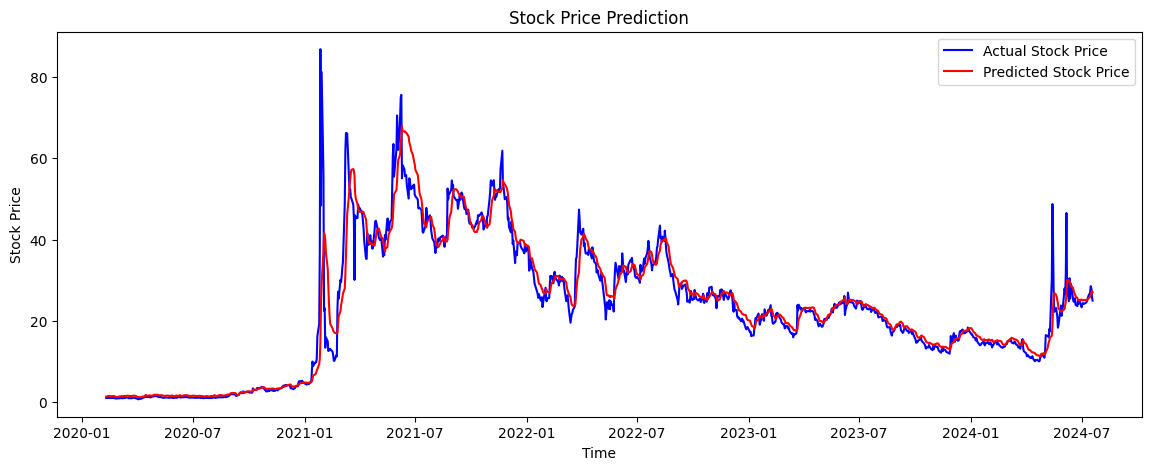

In [29]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(stockPrices.index[-len(predicted_prices):], stockPrices['Close'][-len(predicted_prices):], color='blue', label='Actual Stock Price')
plt.plot(stockPrices.index[-len(predicted_prices):], predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Manipulation Model

In [30]:
# Example feature engineering for manipulation detection
stockPrices['Spread'] = stockPrices['High'] - stockPrices['Low']
stockPrices['Volatility'] = stockPrices['Close'].rolling(window=10).std()
stockPrices['Trade_Ratio'] = stockPrices['Volume'] / stockPrices['Volume'].rolling(window=10).mean()

In [31]:
# Feature scaling
features = ['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'ATR', 'Stochastic', 'OBV', 'Spread', 'Volatility', 'Trade_Ratio']
scaler_fnn = MinMaxScaler()
scaled_data_fnn = scaler_fnn.fit_transform(stockPrices[features])

In [32]:
# Build the Autoencoder model
input_dim = scaled_data_fnn.shape[1]
encoding_dim = 14

In [33]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = Dense(encoding_dim // 2, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [34]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
# Callbacks
autoencoder_checkpoint = ModelCheckpoint('autoencoder_model.keras', save_best_only=True, monitor='val_loss', mode='min')
autoencoder_early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [37]:
autoencoder.fit(scaled_data_fnn, scaled_data_fnn, epochs=100, batch_size=32, validation_split=0.1, callbacks=[autoencoder_checkpoint, autoencoder_early_stop])

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - val_loss: 0.1725
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: 0.1725
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 11/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725


In [39]:
# Use the Autoencoder to predict and calculate reconstruction error
predicted_data = autoencoder.predict(scaled_data_fnn)
mse = np.mean(np.power(scaled_data_fnn - predicted_data, 2), axis=1)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


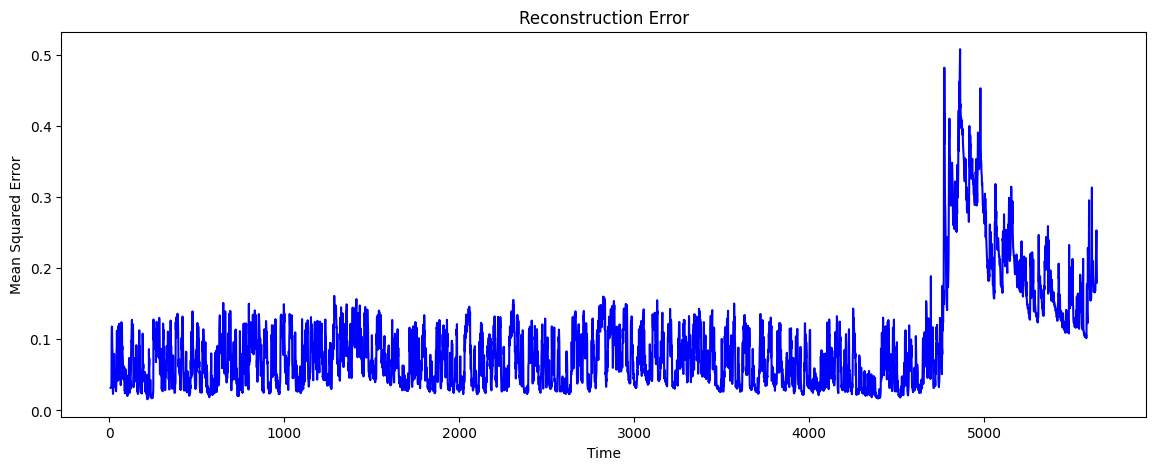

In [40]:
# Plot the reconstruction error
plt.figure(figsize=(14, 5))
plt.plot(mse, color='blue')
plt.title('Reconstruction Error')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.show()

In [41]:
# Define a threshold for anomaly detection
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

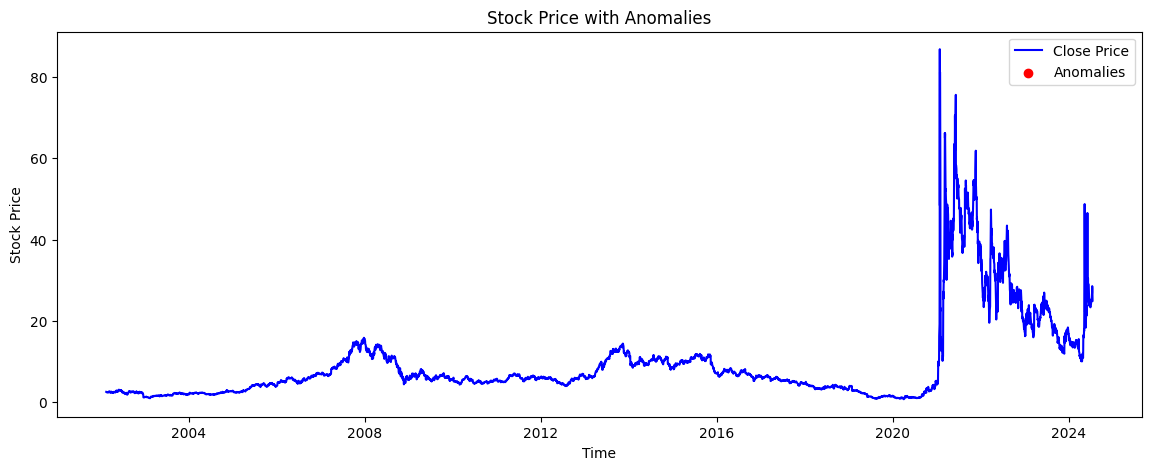

In [42]:
# Plot the anomalies on the original data
plt.figure(figsize=(14, 5))
plt.plot(stockPrices.index, stockPrices['Close'], color='blue', label='Close Price')
plt.scatter(stockPrices.index[anomalies], stockPrices['Close'][anomalies], color='red', label='Anomalies')
plt.title('Stock Price with Anomalies')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()